## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [6]:
fit = sf.data.World.load('data/zshi.sp-102506.metagenotype.filt-poly05-cvrg25-g500.fit-sfacts13-s500-g500-seed0.world.nc')
fit.sizes

Frozen(SortedKeysDict({'strain': 245, 'sample': 9232, 'position': 500, 'allele': 2}))

In [7]:
ref = sf.data.Metagenotypes.load('data/gtprodb.sp-102506.genotype.nc').mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 500})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


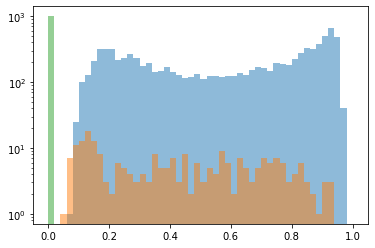

In [8]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-10).entropy(), bins=bins, alpha=0.5)
plt.hist(fit.genotypes.entropy(), bins=bins, alpha=0.5)
plt.hist(ref.entropy(), bins=bins, alpha=0.5)

plt.yscale('log')
None

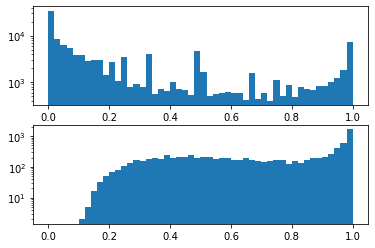

In [9]:
bins = np.linspace(0, 1, num=51)

fig, axs = plt.subplots(2)
axs[0].hist(fit.genotypes.values.flatten(), bins=bins)
axs[1].hist(fit.communities.max("strain").values.flatten(), bins=bins)

for ax in axs:
    ax.set_yscale('log')
None

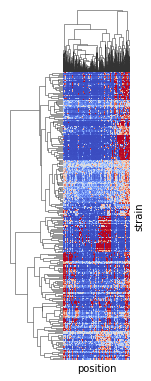

In [10]:
sf.plot.plot_genotype(fit, scaley=2e-2, scalex=1e-3, yticklabels=0)

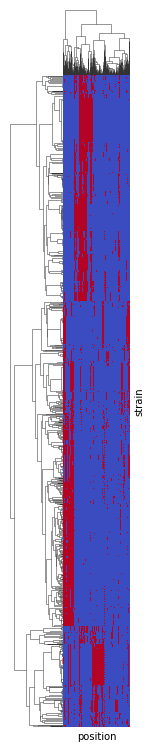

In [11]:
sf.plot.plot_genotype(ref, scaley=1e-2, scalex=1e-3, yticklabels=0)

In [12]:
fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < 0.25)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > 0.25)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 84, 'position': 500}),
 Frozen({'strain': 161, 'position': 500}))

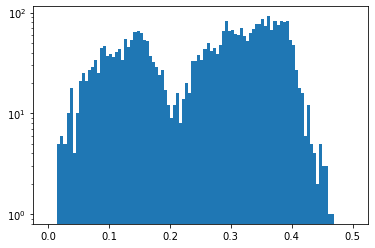

In [13]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

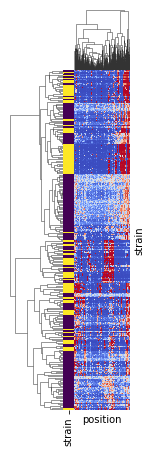

In [14]:
g = sf.data.Genotypes.concat(dict(
    bad=fit_genotypes_highent,
    good=fit_genotypes_filt
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('good'), scaley=2e-2, scalex=1e-3, yticklabels=0)

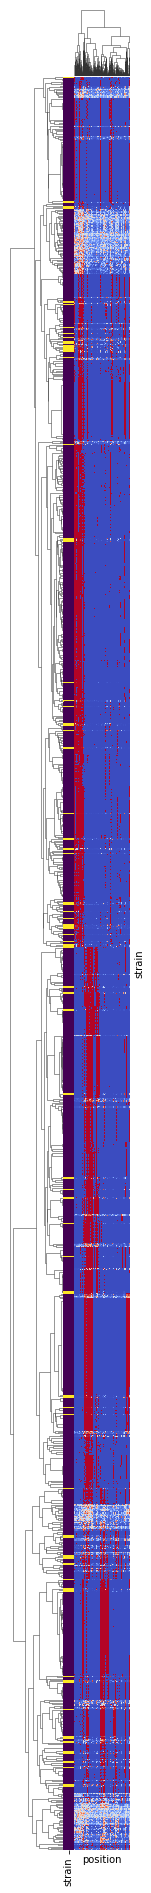

In [15]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
    ent=fit_genotypes_highent,
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

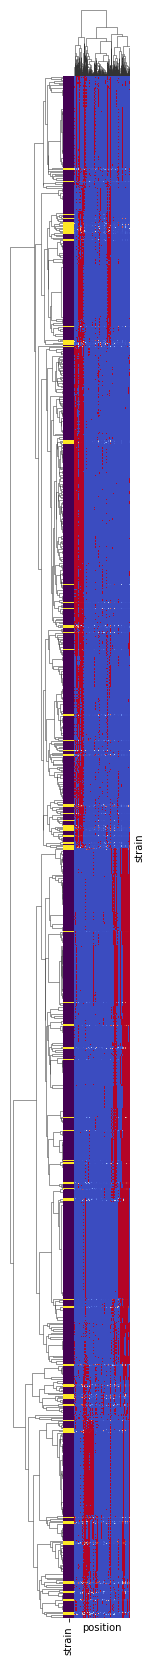

In [16]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
), dim='strain')


sf.plot.plot_genotype(g, row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

In [17]:
sample_meta = pd.read_table('raw/shi2019s13.tsv').set_index('NCBI Accession Number')

sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len)

Continent  Country  Study                
AF         MDG      CM_madagascar            112
           TZA      RampelliS_2015            27
                    SmitsSA_2017              40
AS         BGD      DavidLA_2015              35
           BRN      ChngKR_2016                2
           CHN      ChengpingW_2017           96
                    ChngKR_2016               20
                    HeQ_2017                 118
                    LiJ_2014                   7
                    LiJ_2017                 196
                    QinJ_2012                199
                    QinN_2014                233
                    WenC_2017                168
                    YuJ_2015                 128
           IDN      ChngKR_2016                2
           ISR      ZeeviD_2015              954
           KAZ      CosteaPI_2017            164
           MNG      LiuW_2016                110
           MYS      ChngKR_2016                8
           SGP      ChngKR_

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


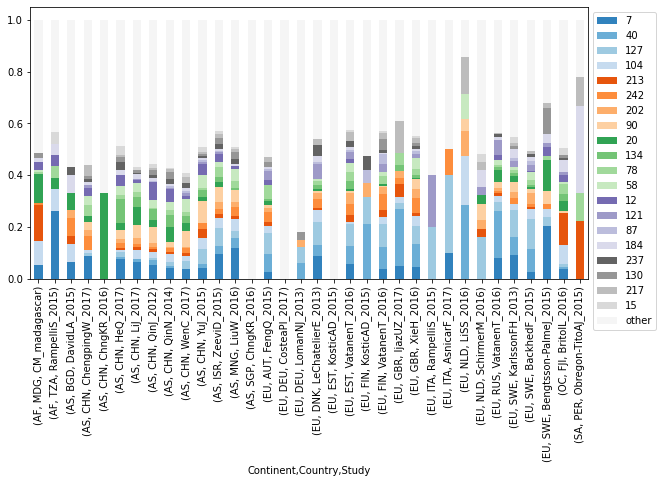

In [18]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

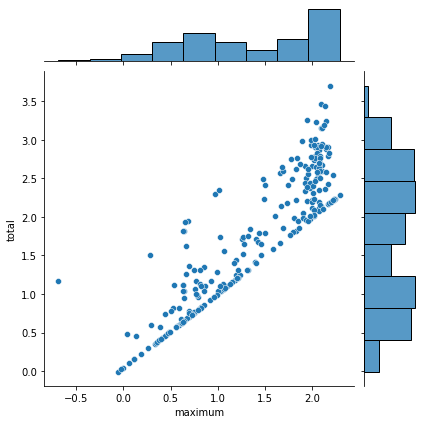

In [19]:
d = pd.DataFrame(dict(
    total=(fit.communities.data * fit.data.mu).sum("sample"),
    maximum=(fit.communities.data * fit.data.mu).max("sample"),
))

sns.jointplot(y='total', x='maximum', data=np.log10(d))

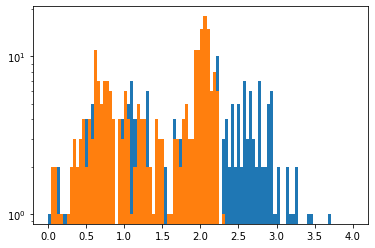

In [20]:
plt.hist((fit.communities.data * fit.data.mu).sum("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101))
plt.hist((fit.communities.data * fit.data.mu).max("sample").to_series().apply(np.log10), bins=np.linspace(0, 4, num=101))

plt.yscale('log')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


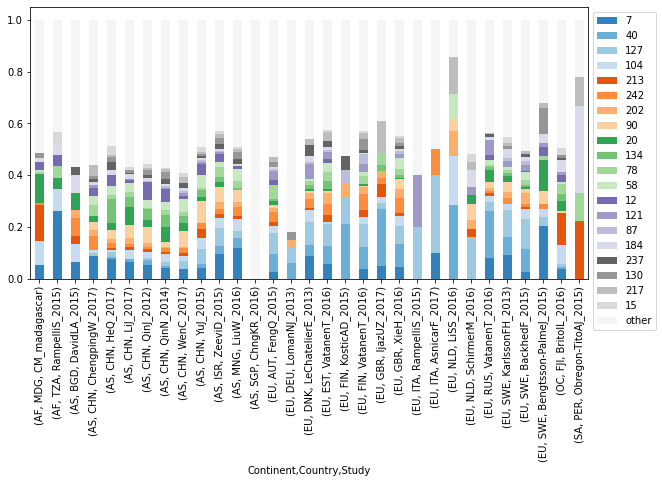

In [21]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


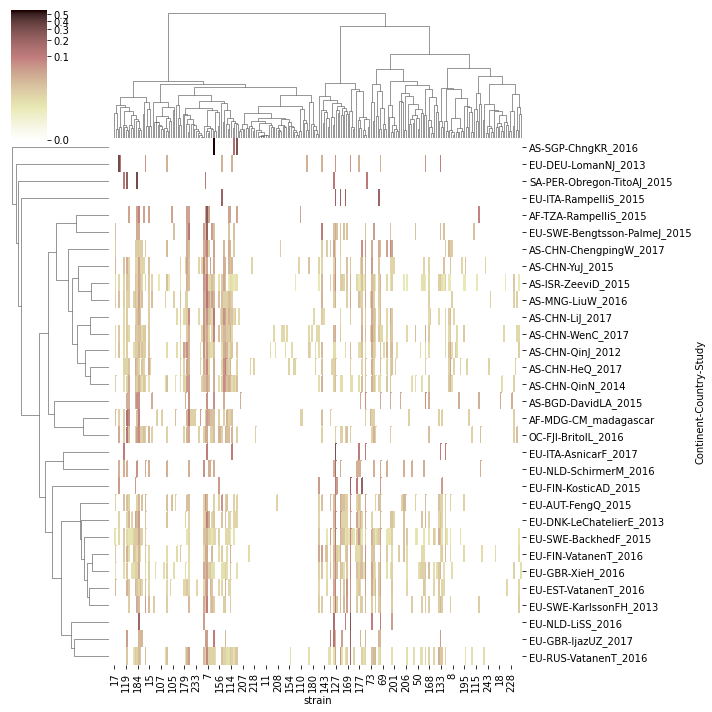

In [28]:
dominant_strain = fit.communities.data.argmax("strain").to_series()
# top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
#     .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
    .reindex(fit.strain, axis='columns')
    .fillna(0)
)


sns.clustermap(
    d1,
    norm=mpl.colors.PowerNorm(1/4),
    col_linkage=fit.genotypes.linkage(),
    metric='cosine',
    cmap='pink_r',
)

In [23]:
clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=0.15, n_clusters=None, affinity='precomputed', linkage='complete'
    ).fit_predict(fit.genotypes.pdist()),
    index=fit.strain,
)


agg_communities = fit.communities.to_series().unstack().groupby(clust, axis='columns').sum()

clust.value_counts()

24    42
4     34
1     17
14    17
12    16
0     15
22    14
9     10
29     8
7      7
11     6
5      6
13     5
8      4
28     4
16     4
25     4
23     4
21     3
2      3
3      3
15     3
10     3
17     3
18     2
26     2
6      2
19     2
20     1
27     1
dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


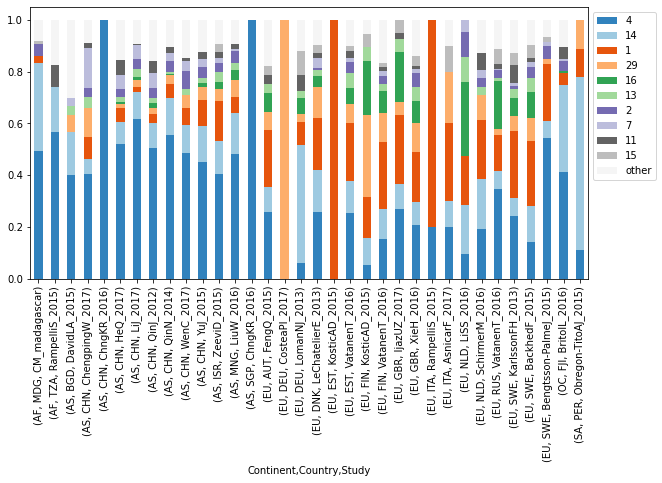

In [24]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(10).index)

d = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [sample_meta.groupby(['Continent', 'Country', 'Study']).apply(len) > 5]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


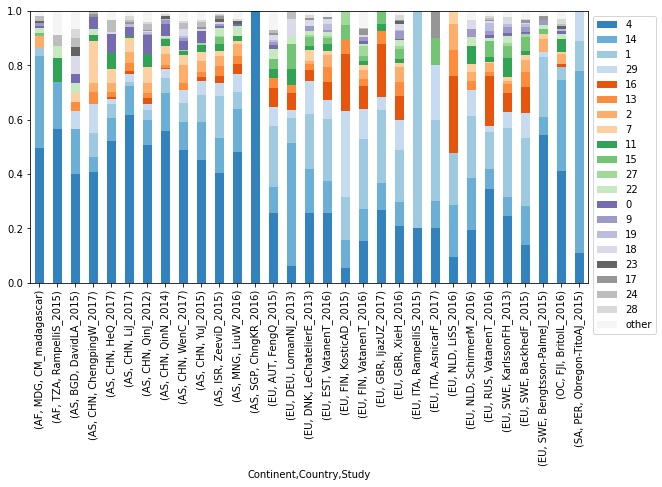

In [25]:
dominant_strain = agg_communities.idxmax(1)
top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
    [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


lib.plot.construct_ordered_pallete(top_strains)

ax = (
    d1
    .plot
    .bar(
        stacked=True, color=lib.plot.construct_ordered_pallete(top_strains, cm='tab20c', other='whitesmoke'),
        figsize=(10, 5)
    )
)
ax.legend(bbox_to_anchor=(1, 1))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


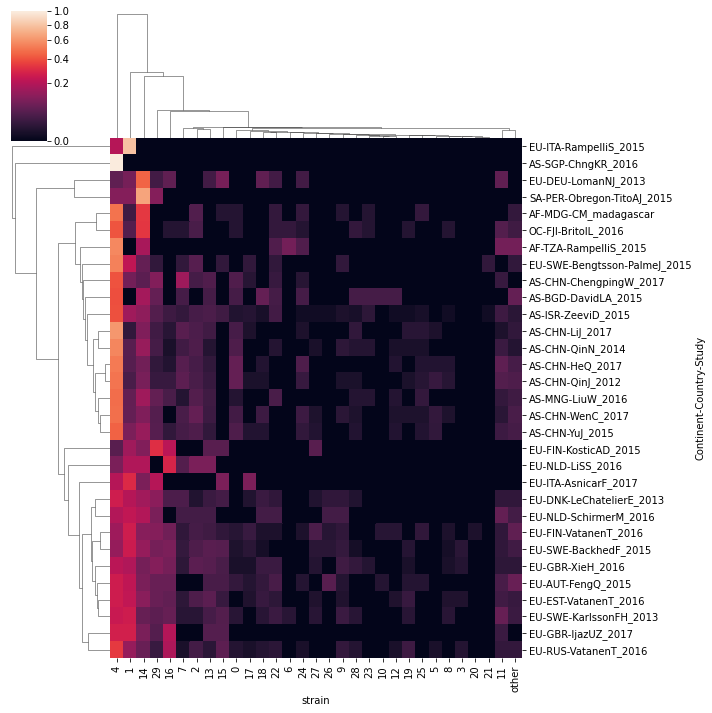

In [26]:
dominant_strain = agg_communities.idxmax(1)
# top_strains = list(dominant_strain.value_counts().sort_values(ascending=False).head(20).index)

d0 = (
    dominant_strain
    .to_frame(name='strain')
    .join(sample_meta, how='inner')
    .groupby(['Continent', 'Country', 'Study', 'strain'])
    .apply(len)
)
    
d1 = (
    d0
    .unstack('strain', fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
    .assign(other=lambda x: 1 - x[top_strains].sum(1))
#     [top_strains + ['other']]
    [(d0.groupby(['Continent', 'Country', 'Study']).sum() >= 5)]
)


sns.clustermap(d1, norm=mpl.colors.PowerNorm(1/2))